In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from transformers import BertTokenizer, TFBertModel
print(tf.__version__)

2.1.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpus))
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

GPUs Available:  0


## insert data
### inspect the data

- multiclass claasification, implicite feedback
- negative sampling
- watched history, the user's gepgraphic region, normalzied feature: [0-1] user's gender, logged-in tstae, age; example age(days since upload); serving:0
- generate a fixed number of training exampls per user (prevent a small cohort of highly actice users from dominating the loss)
- discarding sequence onformation aand represeting search queries with an unordered bag of tokens
- predicting future watch, not predicting held-out watch (what most collaborative filtering systems do)

- a vocabulary of 1M videos and 1M search tokens were embeded with 256 floats each in a maximum bag size of 50 recent watches and 50 recent searches


In [3]:
# basePath = os.path.dirname(os.path.abspath(__file__))
## embeded video watched, embeded search tokens, geographic embeddings, example page, gender
articles = pd.read_csv('data/articles.csv')
users = pd.read_csv('data/user.csv')


In [4]:
articles = articles[[ 'aid', 'title','subTitle','totalClapCount', 'tags','date']]
users = users[['name','bio','searchHist','watchHistTime','watchHist','interests']]
print("columns for article:",articles.columns)
print("columns for user:",users.columns)

columns for article: Index(['aid', 'title', 'subTitle', 'totalClapCount', 'tags', 'date'], dtype='object')
columns for user: Index(['name', 'bio', 'searchHist', 'watchHistTime', 'watchHist', 'interests'], dtype='object')


In [5]:
# get example age and  normalize totalClapCount into 0-1 

In [6]:
articles['example_age'] = (pd.to_datetime("now") - pd.to_datetime(articles['date']))\
            /np.timedelta64(1,'D')

def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

articles = normalize_col(articles,'totalClapCount')
articles = normalize_col(articles,'example_age')
articles.drop(columns={'date'}, inplace = True)

In [7]:
articles.head(5)

,aid,title,subTitle,totalClapCount,tags,example_age
0,4,"Ascent of data Science, SAS and Big data Analy...",Various associations in the present days are o...,0.00000,"['Data Science', 'Sas Training In Pune', 'Hado...",0.310136
1,3,EPQ draft 1 (4844 words),Introduction,0.00000,"['Technology', 'Robotics', 'Automation', 'Epq']",0.400908
2,5,What Is The Importance Of Machine Learning?,Machine learning is the reason for every techn...,0.00000,"['Machine Learning', 'Machine Learning Trainin...",0.000000
3,2,AI VS Dota2 Champions,What do we know about artificial intelligence?...,0.00000,"['Artificial Intelligence', 'Dota 2', 'Cryptoc...",0.127080
4,1,"Private Business, Government and Blockchain",A major private IT company implements blockcha...,0.00753,"['Blockchain', 'Samsung', 'It']",0.016641


In [8]:
users.head(5)

,name,bio,searchHist,watchHistTime,watchHist,interests
0,melodyucros,Entrepreneurial Techie who loves helping start...,[''],"[None, 1809, 8460]","[None, 210, 210]",['Career Change']
1,techdatasolutions18,Tech data Providing Courses Like SaS Training ...,[''],"[None, 4633, 4532]","[None, 386, 386]",['Revnet']
2,babaevanar,NaN,[''],[None],[None],"['Vectorization', 'Farmers', 'Additive M', 'De..."
3,tasty231,NaN,"['', 'OBIZCOIN', 'Classification', 'Evolution'...","[None, 1375, 996, 829, 3966, 4020, 4454, 2168,...","[None, 78, 226, 168, 465, 478, 466, 381, 415, ...","['Obizcoin', 'Io18', 'Classification', 'Evolut..."
4,stewartalsop,NaN,"['', 'Transparency', 'Nips2016', 'Nips']","[None, 2378, 3778, 8930, 6172, 5499]","[None, 126, 128, 390, 52, 52]","['Transparency', 'Nips2016', 'Cloud Tpu']"


In [9]:
users.dtypes

name             object
bio              object
searchHist       object
watchHistTime    object
watchHist        object
interests        object
dtype: object

In [10]:
import ast
def convert_to_list(x):
    # convert string list into list, remove None in list, remove duplicates
    return list(set(list(filter(None.__ne__, ast.literal_eval(x))))) 

def format_list_user(x):
    x['searchHist'] = list(filter(None, ast.literal_eval(x['searchHist'])))
    x['watchHistTime'] = list(filter(None, ast.literal_eval(x['watchHistTime']))) 
    x['watchHist'] = list(filter(None, ast.literal_eval(x['watchHist']))) 
    x['interests'] = list(filter(None, ast.literal_eval(x['interests']))) 
    return x


users = users.apply(format_list_user, axis=1)
articles['tags'] = articles['tags'].apply(convert_to_list)

In [11]:
users.head(5)

,name,bio,searchHist,watchHistTime,watchHist,interests
0,melodyucros,Entrepreneurial Techie who loves helping start...,[],"[1809, 8460]","[210, 210]",[Career Change]
1,techdatasolutions18,Tech data Providing Courses Like SaS Training ...,[],"[4633, 4532]","[386, 386]",[Revnet]
2,babaevanar,NaN,[],[],[],"[Vectorization, Farmers, Additive M, Decision ..."
3,tasty231,NaN,"[OBIZCOIN, Classification, Evolution, Mechanic...","[1375, 996, 829, 3966, 4020, 4454, 2168, 3969,...","[78, 226, 168, 465, 478, 466, 381, 415, 421]","[Obizcoin, Io18, Classification, Evolution, Me..."
4,stewartalsop,NaN,"[Transparency, Nips2016, Nips]","[2378, 3778, 8930, 6172, 5499]","[126, 128, 390, 52, 52]","[Transparency, Nips2016, Cloud Tpu]"


In [12]:
assert (users['watchHistTime'].apply(len) == users['watchHist'].apply(len)).all()

In [13]:
# active users

In [14]:
act_users = users.copy()
act_users['watchHist'] = act_users['watchHist'].apply(lambda x: list(set(x))) # remove duplicated watched item ids
act_users = act_users.explode('watchHist')
act_users = act_users.drop(columns = {'watchHistTime'})
act_users['bio'] = act_users['bio'].fillna(' ')

act_users = act_users.dropna()

In [15]:
act_users.shape

(287, 5)

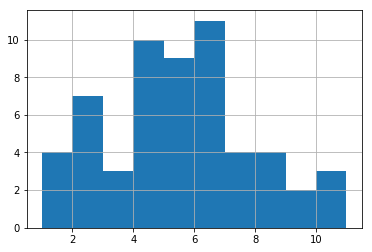

In [16]:
act_users.groupby('name')['watchHist'].count().hist()

In [17]:
act_users.groupby('name')['watchHist'].count().describe()

count    57.000000
mean      5.035088
std       2.427263
min       1.000000
25%       4.000000
50%       5.000000
75%       6.000000
max      11.000000
Name: watchHist, dtype: float64

In [18]:
# act_users.groupby('name')['watchHist'].count()

In [19]:
# meas search amount is 5, generate 10 for each user

In [20]:
articles.columns

Index(['aid', 'title', 'subTitle', 'totalClapCount', 'tags', 'example_age'], dtype='object')

In [21]:
train_pos = pd.merge(act_users,articles, left_on=['watchHist'],right_on =['aid'],how='inner')\
        .drop(columns = ['watchHist'])

In [22]:
train_pos.shape

(287, 10)

In [23]:
user_need_sample= act_users.groupby('name')['watchHist'].count().reset_index(name = 'count')

negative_list = []
for index, row in user_need_sample.iterrows():
    temp = articles.sample(n= 12 - row['count'])
    temp['name'] = row['name']
    negative_list.append(temp)

negative_df = pd.concat(negative_list)

In [24]:
negative_df.columns

Index(['aid', 'title', 'subTitle', 'totalClapCount', 'tags', 'example_age',
       'name'],
      dtype='object')

In [25]:
len(negative_list)

57

In [26]:
train_pos.columns

Index(['name', 'bio', 'searchHist', 'interests', 'aid', 'title', 'subTitle',
       'totalClapCount', 'tags', 'example_age'],
      dtype='object')

In [27]:
act_users.columns

Index(['name', 'bio', 'searchHist', 'watchHist', 'interests'], dtype='object')

In [28]:
negative_df.shape

(397, 7)

In [29]:
len(users['name'].unique())

100

In [30]:
trian_neg = pd.merge(negative_df,users,on=['name'],how='inner').sample(n=train_pos.shape[0])

In [31]:
trian_neg.columns

Index(['aid', 'title', 'subTitle', 'totalClapCount', 'tags', 'example_age',
       'name', 'bio', 'searchHist', 'watchHistTime', 'watchHist', 'interests'],
      dtype='object')

In [32]:
trian_neg.shape

(287, 12)

In [33]:
act_users.shape

(287, 5)

In [34]:
# remove the negative articles that appeared in watched list
trian_neg['deleted'] = trian_neg.apply(lambda x: x['aid'] in x['watchHist'], axis=1)
trian_neg = trian_neg[trian_neg['deleted']==False].drop(columns={'watchHist','deleted','watchHistTime'})

In [35]:
trian_neg['label'] = 0
train_pos['label'] = train_pos['aid']

In [36]:
train_data = pd.concat([train_pos,trian_neg])
train_data = train_data.drop(columns={'aid','name'})

/Users/rachelchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [37]:
train_data.isnull().any()

bio                True
example_age       False
interests         False
label             False
searchHist        False
subTitle           True
tags              False
title             False
totalClapCount    False
dtype: bool

In [38]:
train_data['subTitle'] = train_data['subTitle'].fillna('')
train_data['bio'] = train_data['bio'].fillna('')

In [39]:
train_data.shape

(568, 9)

In [40]:
train_data.columns

Index(['bio', 'example_age', 'interests', 'label', 'searchHist', 'subTitle',
       'tags', 'title', 'totalClapCount'],
      dtype='object')

In [41]:
## use the embedding 

In [42]:
train_data.columns

Index(['bio', 'example_age', 'interests', 'label', 'searchHist', 'subTitle',
       'tags', 'title', 'totalClapCount'],
      dtype='object')

In [43]:
## preprare for bert embedding

In [44]:
train_data['interests'] = train_data['interests'].apply(lambda x: ' '.join(x))
train_data['tags'] = train_data['tags'].apply(lambda x: ' '.join(x))
train_data['searchHist'] = train_data['searchHist'].apply(lambda x: ' '.join(x))

train_data['article_emb'] = train_data['title']+ train_data['subTitle']+train_data['tags'] 
train_data['user_beh_emb'] = train_data['searchHist'] 
train_data['user_emb'] = train_data['bio'] + train_data['interests']

train_data = train_data[['article_emb','user_beh_emb','user_emb','totalClapCount','label','example_age']]

In [45]:
def get_bert_emb(df,col_name,max_length=10):
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = TFBertModel.from_pretrained('bert-base-cased')
    batch_encoding = tokenizer.batch_encode_plus(df[col_name].tolist(), max_length=max_length, pad_to_max_length=True)

    outputs = model(tf.convert_to_tensor(batch_encoding['input_ids'])) # shape: (batch,sequence length, hidden state)
    embeddings_video = tf.reduce_mean(outputs[0],1)
    return embeddings_video.numpy().tolist(),batch_encoding['input_ids']

In [46]:
# train_data.head(10)

In [47]:
train_data.isna().any()

article_emb       False
user_beh_emb      False
user_emb          False
totalClapCount    False
label             False
example_age       False
dtype: bool

In [48]:
# average the histrical article embedding 
# average user_beh_embedding 
# user_emb 

# multi-class problem

In [49]:
train_data['article_emb_bert'],train_data['article_emb_inputid'] = get_bert_emb(train_data,'article_emb')
train_data['user_beh_emb_bert'],train_data['user_beh_emb_inputid'] = get_bert_emb(train_data,'user_beh_emb')
train_data['user_emb_bert'],train_data['user_emb_inputid'] = get_bert_emb(train_data,'user_emb')

In [50]:
train_data['example_age_square'] = train_data['example_age'].map(np.square)

In [51]:
train_data.columns

Index(['article_emb', 'user_beh_emb', 'user_emb', 'totalClapCount', 'label',
       'example_age', 'article_emb_bert', 'article_emb_inputid',
       'user_beh_emb_bert', 'user_beh_emb_inputid', 'user_emb_bert',
       'user_emb_inputid', 'example_age_square'],
      dtype='object')

In [52]:
train_data.head(5)

,article_emb,user_beh_emb,user_emb,totalClapCount,label,example_age,article_emb_bert,article_emb_inputid,user_beh_emb_bert,user_beh_emb_inputid,user_emb_bert,user_emb_inputid,example_age_square
0,Making the SwitchThe Painstakingly Slow Beginn...,,Entrepreneurial Techie who loves helping start...,0.000000,210,0.039334,"[0.22904324531555176, 0.02765187993645668, 0.1...","[101, 10697, 1103, 156, 18548, 1942, 4638, 133...","[-0.17436088621616364, -0.2535916566848755, 0....","[101, 102, 0, 0, 0, 0, 0, 0, 0, 0]","[0.33958497643470764, 0.15296240150928497, 0.0...","[101, 13832, 7877, 1643, 16717, 19700, 1233, 7...",0.001547
1,"Code with Eager Execution, Run with Graphs: Op...",,Tech data Providing Courses Like SaS Training ...,0.007078,386,0.077156,"[0.10684485733509064, 0.19496707618236542, 0.2...","[101, 6741, 1114, 142, 12344, 16409, 10294, 12...","[-0.17436088621616364, -0.2535916566848755, 0....","[101, 102, 0, 0, 0, 0, 0, 0, 0, 0]","[0.2618952691555023, 0.13922862708568573, -0.1...","[101, 7882, 2233, 5096, 18312, 1158, 10176, 11...",0.005953
2,"Code with Eager Execution, Run with Graphs: Op...",,Computer Science Undergrad trying to figure st...,0.007078,386,0.077156,"[0.10684485733509064, 0.19496707618236542, 0.2...","[101, 6741, 1114, 142, 12344, 16409, 10294, 12...","[-0.17436088621616364, -0.2535916566848755, 0....","[101, 102, 0, 0, 0, 0, 0, 0, 0, 0]","[0.15719716250896454, 0.2271394282579422, 0.09...","[101, 6701, 2444, 2831, 20561, 1774, 1106, 248...",0.005953
3,Application of Random Forest Algorithm in Remo...,OBIZCOIN Classification Evolution Mechanical M...,Obizcoin Io18 Classification Evolution Mechan...,0.000000,226,0.240545,"[0.02249579131603241, 0.12434376776218414, -0....","[101, 22491, 1104, 19441, 4089, 2586, 18791, 7...","[0.13140153884887695, -0.12303154170513153, -0...","[101, 152, 24963, 5301, 15678, 11607, 19295, 1...","[0.5636561512947083, -0.11189024150371552, 0.1...","[101, 152, 5567, 1584, 2528, 1394, 146, 1186, ...",0.057862
4,Application of Random Forest Algorithm in Remo...,Tech Data,Freelance writer and content marketer. Mainly ...,0.000000,226,0.240545,"[0.02249579131603241, 0.12434376776218414, -0....","[101, 22491, 1104, 19441, 4089, 2586, 18791, 7...","[0.06514380872249603, -0.1176924854516983, 0.3...","[101, 7882, 7154, 102, 0, 0, 0, 0, 0, 0]","[0.4467066824436188, -0.12890012562274933, 0.0...","[101, 4299, 13831, 2432, 1105, 3438, 2319, 120...",0.057862


In [52]:
# values = train_data[['article_emb_inputid','user_beh_emb_inputid','user_emb_inputid']].values
# values = train_data[['article_emb_inputid','user_beh_emb_inputid','user_emb_inputid']].values\
#         .reshape(values.shape[0]*values.shape[1],)
# values = list(set([item for sublist in values for item in sublist]))

In [53]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
label_trans = lb.fit_transform(train_data['label'])

In [54]:
label_trans.shape

(568, 187)

In [55]:
#### wrong: the feature shape is (example_num, feature_amount(768)), it can not be embeeding, 
### where embedding is for each word, built a vector 

In [56]:
# num_tags = 12  # Number of unique issue tags
# num_words = 10000  # Size of vocabulary obtained when preprocessing text data
# num_departments = 4  # Number of departments for predictions

# article_input = tf.keras.Input(
#     shape=(None,), name="article"
# )  
# userbeh_input = tf.keras.Input(shape=(None,), name="userbehaviour")  

# user_input = tf.keras.Input(
#     shape=(None,), name="user"
# )  

# article_features = tf.keras.layers.Embedding(np.array(train_data['article_emb_bert'].values.tolist()).shape[0], 
#                                              np.array(train_data['article_emb_bert'].values.tolist()).shape[1], 
#                                     weights=[np.array(train_data['article_emb_bert'].values.tolist())], 
#                                     input_length=4, trainable=True)(article_input)
# user_beh_features = tf.keras.layers.Embedding(np.array(train_data['user_beh_emb_bert'].values.tolist()).shape[0],
#                                               np.array(train_data['user_beh_emb_bert'].values.tolist()).shape[1], 
#                                     weights=[np.array(train_data['user_beh_emb_bert'].values.tolist())], 
#                                     input_length=4, trainable=True)(userbeh_input)
# user_features = tf.keras.layers.Embedding(np.array(train_data['user_emb_bert'].values.tolist()).shape[0], 
#                                           np.array(train_data['user_emb_bert'].values.tolist()).shape[1], 
#                                     weights=[np.array(train_data['user_emb_bert'].values.tolist())], 
#                                     input_length=4, trainable=True)(user_input)

# # Merge all available features into a single large vector via concatenation
# x = tf.keras.layers.concatenate([article_features, user_beh_features, user_features])

# # Stick a logistic regression for priority prediction on top of the features
# hidden_layer = tf.keras.layers.Dense(256, activation='relu', name="relu")(x)
# priority_pred = tf.keras.layers.Dense(187, activation= 'softmax', name="priority")(hidden_layer)

# # Instantiate an end-to-end model predicting both priority and department
# model = tf.keras.Model(
#     inputs=[article_input, userbeh_input, user_input],
#     outputs=priority_pred,
# )
# model.compile(optimizer='adam',
#             loss="categorical_crossentropy",
#             metrics=['accuracy'])
# model.fit([tf.convert_to_tensor(train_data['article_emb_inputid']),
#            tf.convert_to_tensor(train_data['user_beh_emb_inputid']),
#            tf.convert_to_tensor(train_data['user_emb_inputid'])],
#           label_trans, epochs=50, shuffle=True)

In [57]:
#### set these features as fixed input 
article_input = tf.keras.Input(
    shape=(768,), name="article"
)  
userbeh_input = tf.keras.Input(shape=(768,), name="userbehaviour")  

user_input = tf.keras.Input(
    shape=(768,), name="user"
) 
x = tf.keras.layers.concatenate([article_input, userbeh_input, user_input])

hidden_layer = tf.keras.layers.Dense(256, activation='relu', name="relu")(x)
priority_pred = tf.keras.layers.Dense(187, activation= 'softmax', name="priority")(hidden_layer)

model = tf.keras.Model(
    inputs=[article_input, userbeh_input, user_input],
    outputs=priority_pred,
)


In [58]:
model.compile(optimizer='adam',
            loss="categorical_crossentropy",
            metrics=['accuracy'])

In [60]:
model.fit([tf.convert_to_tensor(train_data['article_emb_bert']),
           tf.convert_to_tensor(train_data['user_beh_emb_bert']),
           tf.convert_to_tensor(train_data['user_emb_bert'])],
          label_trans, epochs=50, shuffle=True)

Train on 568 samples
Epoch 1/50
568/568 [==============================] - 0s 571us/sample - loss: 3.7320 - accuracy: 0.4718
Epoch 2/50
568/568 [==============================] - 0s 83us/sample - loss: 3.0865 - accuracy: 0.4947
Epoch 3/50
568/568 [==============================] - 0s 79us/sample - loss: 2.7668 - accuracy: 0.4982
Epoch 4/50
568/568 [==============================] - 0s 81us/sample - loss: 2.4772 - accuracy: 0.5317
Epoch 5/50
568/568 [==============================] - 0s 82us/sample - loss: 2.1959 - accuracy: 0.5493
Epoch 6/50
568/568 [==============================] - 0s 79us/sample - loss: 1.9373 - accuracy: 0.5687
Epoch 7/50
568/568 [==============================] - 0s 81us/sample - loss: 1.7172 - accuracy: 0.5951
Epoch 8/50
568/568 [==============================] - 0s 84us/sample - loss: 1.4470 - accuracy: 0.6215
Epoch 9/50
568/568 [==============================] - 0s 86us/sample - loss: 1.1957 - accuracy: 0.6655
Epoch 10/50
568/568 [==============================

In [59]:
tf.convert_to_tensor(train_data['article_emb_bert']).shape

TensorShape([568, 768])

In [49]:
dim_len = len(train_data['article_emb'].head(1).values.tolist()[0])

In [50]:
article_emb_cols = ['article_emb_'+str(i) for i in range(0,dim_len)]
user_beh_emb_cols = ['user_beh_emb_'+str(i) for i in range(0,dim_len)]
user_emb_cols = ['user_emb'+str(i) for i in range(0,dim_len)]

In [51]:
train_data = pd.concat([pd.DataFrame(train_data.article_emb.tolist(),index= train_data.index,columns=article_emb_cols),
                       pd.DataFrame(train_data.user_beh_emb.tolist(),index= train_data.index,columns=user_beh_emb_cols),
                       pd.DataFrame(train_data.user_emb.tolist(),index= train_data.index,columns=user_emb_cols),
                       train_data[['totalClapCount','example_age_square','example_age','label']]
                      ],axis=1, sort=False)

In [52]:
train_data.shape

(571, 2308)

In [53]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_data, test_size=0.2)

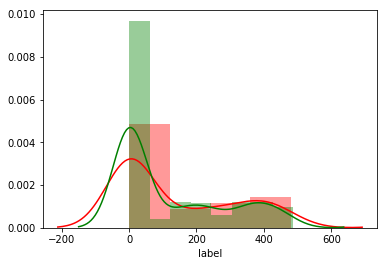

In [54]:
sns.distplot(test['label'], color='red')
sns.distplot(train['label'], color='green')

In [55]:
strategy = tf.distribute.MirroredStrategy()

BUFFER_SIZE = train.shape[0]

BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCHS = 10

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
## recommend based on the most watched video content

In [56]:
train_data.shape

(571, 2308)

In [57]:
train_data.columns

Index(['article_emb_0', 'article_emb_1', 'article_emb_2', 'article_emb_3',
       'article_emb_4', 'article_emb_5', 'article_emb_6', 'article_emb_7',
       'article_emb_8', 'article_emb_9',
       ...
       'user_emb762', 'user_emb763', 'user_emb764', 'user_emb765',
       'user_emb766', 'user_emb767', 'totalClapCount', 'example_age_square',
       'example_age', 'label'],
      dtype='object', length=2308)

In [55]:
item_num = len(articles['aid'].unique())
embedding_size = 256

initializer = tf.random_uniform_initializer(minval=-0.5 / embedding_size, maxval=0.5 / embedding_size)
partitioner = tf.compat.v1.fixed_size_partitioner(num_shards=embedding_size)
item_embedding = tf.compat.v1.get_variable("item_embedding", 
                                 [item_num, embedding_size],
                                 tf.float32, 
                                 initializer=initializer, 
                                 partitioner=partitioner)


def mapped_function(train, label):
    return train, tf.nn.embedding_lookup(item_embedding, label)

train_dataset =tf.data.Dataset.from_tensor_slices((train.drop(columns={'label'}).values, train['label'].values))\
                                .map(mapped_function)\
                                .shuffle(BUFFER_SIZE)\
                                .batch(GLOBAL_BATCH_SIZE)\
                                .prefetch(buffer_size =tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test.drop(columns={'label'}).values, test['label'].values))\
                                .map(mapped_function)\
                                .batch(GLOBAL_BATCH_SIZE)\
                                .prefetch(buffer_size =tf.data.experimental.AUTOTUNE)

# train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
# test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

In [57]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore').fit(train_data[['label']].values)

train_dataset =tf.data.Dataset.from_tensor_slices((train.drop(columns={'label'}).values, enc.transform(train[['label']].values).toarray()))\
                                .shuffle(BUFFER_SIZE)\
                                .batch(GLOBAL_BATCH_SIZE)\
                                .prefetch(buffer_size =tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test.drop(columns={'label'}).values, enc.transform(test[['label']].values).toarray()))\
                                .batch(GLOBAL_BATCH_SIZE)\
                                .prefetch(buffer_size =tf.data.experimental.AUTOTUNE)



In [81]:
for x,y in train_dataset.take(1):
    print(y)

tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 187), dtype=float64)


In [84]:

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(train.shape[1]-1,)))

model.add(tf.keras.layers.Dense(units=2048, activation='relu'))
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=187, activation='softmax'))

model.compile(optimizer='adam',
            loss="categorical_crossentropy",
            metrics=['accuracy'])
 

history = model.fit(train_dataset, epochs=50, shuffle=True, validation_data=test_dataset)

# To track the progression of training, gather a snapshot
# of the model's metrics at each epoch. 
epochs = history.epoch
hist = pd.DataFrame(history.history)

Train for 9 steps, validate for 3 steps
Epoch 1/50
9/9 [==============================] - 1s 89ms/step - loss: 3.5859 - accuracy: 0.5018 - val_loss: 2.7330 - val_accuracy: 0.6496
Epoch 2/50
9/9 [==============================] - 0s 33ms/step - loss: 2.9317 - accuracy: 0.5607 - val_loss: 3.1179 - val_accuracy: 0.6496
Epoch 3/50
9/9 [==============================] - 0s 34ms/step - loss: 2.8668 - accuracy: 0.5607 - val_loss: 2.9151 - val_accuracy: 0.6496
Epoch 4/50
9/9 [==============================] - 0s 37ms/step - loss: 2.6779 - accuracy: 0.5607 - val_loss: 2.9388 - val_accuracy: 0.6496
Epoch 5/50
9/9 [==============================] - 0s 36ms/step - loss: 2.5724 - accuracy: 0.5607 - val_loss: 2.9145 - val_accuracy: 0.6496
Epoch 6/50
9/9 [==============================] - 0s 35ms/step - loss: 2.2681 - accuracy: 0.5625 - val_loss: 2.9996 - val_accuracy: 0.6496
Epoch 7/50
9/9 [==============================] - 0s 34ms/step - loss: 2.0493 - accuracy: 0.5846 - val_loss: 3.2214 - val_accu

In [56]:
# use the embedding 
train_data.columns

Index(['article_emb_0', 'article_emb_1', 'article_emb_2', 'article_emb_3',
       'article_emb_4', 'article_emb_5', 'article_emb_6', 'article_emb_7',
       'article_emb_8', 'article_emb_9',
       ...
       'user_emb762', 'user_emb763', 'user_emb764', 'user_emb765',
       'user_emb766', 'user_emb767', 'totalClapCount', 'example_age_square',
       'example_age', 'label'],
      dtype='object', length=2308)